In [1]:
# Questi comandi permettono di usare in Jupyter le librerie di R presenti nel CRAN (Comprehensive R Archive Network)
country.code <- 'it'
url.pattern <- 'https://'  
repo.data.frame <- subset(getCRANmirrors(), CountryCode == country.code & grepl(url.pattern, URL))
options(repos = repo.data.frame$URL)

In [2]:
# Package utili: psych per le funzioni di stima dei parametri e readxl per poter leggere file excel
install.packages("psych")
install.packages("readxl")
library(psych)
library("readxl")

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\RtmpmQqZgs\downloaded_packages
package 'readxl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\RtmpmQqZgs\downloaded_packages


In [3]:
# Classe per un oggetto di 2 campi: lista di difficoltà e lista di abilità
setClass(
  "IrtParameters",
  representation(difficulties="array", abilities="numeric"),
)

setGeneric("getDiff", 
    function(object) { 
        standardGeneric("getDiff") 
    } 
)

setGeneric("getAbil", 
    function(object) { 
        standardGeneric("getAbil") 
    } 
)

setMethod("getDiff", signature("IrtParameters"),
  function(object) {
    object@difficulties
  }
)

setMethod("getAbil", signature("IrtParameters"),
  function(object) {
    object@abilities
  }
)

[1] "getDiff"

[1] "getAbil"

[1] "getDiff"

[1] "getAbil"

In [8]:
# Funzioni per leggere dati da csv ed excel e impostare la prima colonna degli studenti come indici
readCSV <- function(path) {
  read.csv(path, row.names = 1)
}

readEXCEl <- function(path) {
    items <- read_excel(path)
    items <- as.data.frame(items)
    rownames(items) <- items[,1]
    items <- items[,-1]
    items
}

In [9]:
# Funzione per stimare le difficoltà e creare il grafico
estimateDifficulties <- function(items, plot = TRUE) {
  diff <- irt.item.diff.rasch(items)
  diff[which(!is.finite(diff))] <- -4
  
  if (plot) {
    nItems = length(items)
    plot(diff,xlim=c(1,nItems),ylim=c(-4,4),type="b",main="Difficulties plot",xlab="Items",ylab="Difficulty",xaxt="n",col="red",pch=16,lwd=2)
    axis(1, at=1:nItems, labels=names(items))
    par(new = TRUE)
    plot(diff + 3.7, type = "h", xlim = c(1,nItems),ylim = c(0,8), xaxt='n', yaxt = "n", xlab = "", ylab = "", lty = 2)          
  }
  array(diff)
}

# Funzione per stimare le abilità e creare l'istogramma
estimateAbilities <- function(items, plot = TRUE) {
    info <- irt.0p(items)
    info <- data.frame(info)
    theta <- info$theta0
    if (plot) {
        hist(theta,main="Ability histogram",xlab="Ability",ylab="Students",breaks=seq(-3,3,by=0.5),xlim=c(-3,3),col="royalblue3")
        axis(1, at=seq(-3, 3, by=0.5), labels=seq(-3, 3, by=0.5))        
    } 
    theta
}

estimateParameters<- function(items, plotDifficulties = TRUE, plotAbilities = TRUE) {
    options(repr.plot.width=12, repr.plot.height=6) # ridimensiono plot
    par(mfrow=c(1,2)) # 2 plot sulla stessa riga
    diff <- estimateDifficulties(items, plotDifficulties)
    abilities <- estimateAbilities(items, plotAbilities)
    new("IrtParameters", difficulties=diff, abilities=abilities)
}

# Funzione per il calcolo della probabilità che uno studente con una certa abilità passi un esercizio con una certa difficoltà
pl1 <- function(ability, difficulty) {
    exp(ability - difficulty) / (1 + exp(ability - difficulty))
}

# Funzione per generare una matrice di probabilità date difficoltà e abilità
correctProbabilites <- function(items, diff, abil) {
    probDf <- items
    namesCol <- names(probDf)
    namesRow <- row.names(probDf)
    j <- 1
    for (row in namesRow) {
        i <- 1
        for (col in namesCol) {
            prob <- pl1(abil[j],diff[i])
            perc <- round(prob * 100, digits = 0)
            probDf[row,col] <- paste(perc,"%")
            i <- i + 1
        }
        j <- j + 1
    }
    probDf
}

In [10]:
# Esempio con tabella dicotomica, 1 = SN ha passato l'esercizio en, 0 altrimenti
#items <- readCSV("EsameCSV.csv")
items <- readEXCEl("EsameEXCEL.xlsx")
items

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,1,1,1,1,1,1,1,1,1,0
S2,1,0,0,0,0,0,0,0,0,0
S3,1,1,1,1,0,1,1,1,1,0
S4,1,1,1,1,1,1,1,1,1,0
S5,1,1,1,1,1,1,0,0,0,0
S6,1,1,1,1,1,0,1,1,1,0
S7,1,1,0,1,1,1,1,0,0,0
S8,1,1,1,1,0,1,0,1,1,0
S9,1,1,1,1,1,0,1,1,1,0
S10,1,1,1,1,1,0,1,1,0,0


An object of class "IrtParameters"
Slot "difficulties":
 [1] -4.0000000 -2.4423470 -1.3862944 -1.9924302 -0.9444616 -0.5753641
 [7] -0.7537718 -0.4054651 -0.4054651  3.1780538

Slot "abilities":
 [1]  2.1972246 -2.1972246  1.3862944  2.1972246  0.4054651  1.3862944
 [7]  0.4054651  0.8472979  1.3862944  0.8472979  0.8472979  0.0000000
[13]  0.4054651  1.3862944  0.8472979  0.0000000  0.4054651  1.3862944
[19]  0.4054651  0.8472979  1.3862944 -0.4054651  1.3862944  1.3862944
[25]  2.1972246


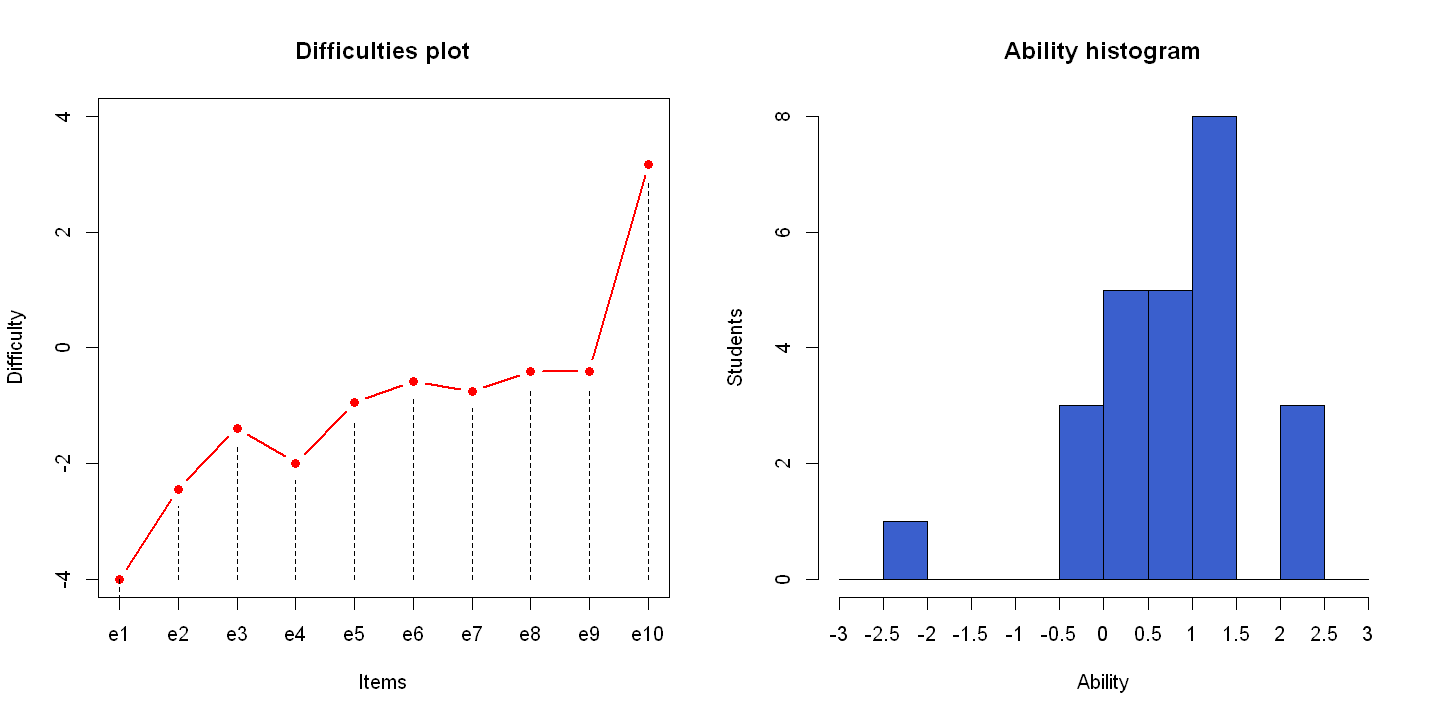

In [11]:
# la funzione estimateParameters prende in input la tabella dicotomica, restituisce un oggetto di tipo IrtParameters con 2 
# campi, uno per le difficoltà stimate e uno per le abilità stimate, se non si specifica altrimenti verranno anche visualizzati
# i relativi grafici
param <- estimateParameters(items)
param

In [12]:
# La funzione correctProbabilites prende in input la tabella dicotomica, le difficoltà e le abilità per generare una tabella
# nelle cui intersezioni vi sono le probabilità che SN superi l'esercizio en
correctProbabilites(items, getDiff(param), getAbil(param))

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,100 %,99 %,97 %,99 %,96 %,94 %,95 %,93 %,93 %,27 %
S2,86 %,56 %,31 %,45 %,22 %,16 %,19 %,14 %,14 %,0 %
S3,100 %,98 %,94 %,97 %,91 %,88 %,89 %,86 %,86 %,14 %
S4,100 %,99 %,97 %,99 %,96 %,94 %,95 %,93 %,93 %,27 %
S5,99 %,95 %,86 %,92 %,79 %,73 %,76 %,69 %,69 %,6 %
S6,100 %,98 %,94 %,97 %,91 %,88 %,89 %,86 %,86 %,14 %
S7,99 %,95 %,86 %,92 %,79 %,73 %,76 %,69 %,69 %,6 %
S8,99 %,96 %,90 %,94 %,86 %,81 %,83 %,78 %,78 %,9 %
S9,100 %,98 %,94 %,97 %,91 %,88 %,89 %,86 %,86 %,14 %
S10,99 %,96 %,90 %,94 %,86 %,81 %,83 %,78 %,78 %,9 %
